# Model Development

**Carlos Bustillo | Prosigliere Tech Interview**
<br>I'm using GPU T4 on Google Colab

## 0) Dependencies

In [1]:
!pip3 install xgboost

In [9]:
import os
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from imblearn.over_sampling import SMOTE

## 1) Load datasets

Load from local all the cleaned data
<br>They were obtained using the first notebook (0__EDA.ipynb)

In [3]:
!unzip "/content/processed_data.zip"

Archive:  /content/processed_data.zip
replace content/processed_data/X_test.joblib? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
processed_dir = "/content/content/processed_data"

X_train = joblib.load(os.path.join(processed_dir, "X_train.joblib"))
y_train = joblib.load(os.path.join(processed_dir, "y_train.joblib"))
X_val   = joblib.load(os.path.join(processed_dir, "X_val.joblib"))
y_val   = joblib.load(os.path.join(processed_dir, "y_val.joblib"))
X_test  = joblib.load(os.path.join(processed_dir, "X_test.joblib"))
y_test  = joblib.load(os.path.join(processed_dir, "y_test.joblib"))

Balance data using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## 2) Define models

In [24]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1.0, probability=True, gamma='scale', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, eval_metric='logloss', random_state=42),
}

## 3) Train and Evaluate

In [25]:
results = {}

for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_score_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    y_score_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    report = classification_report(y_test, y_pred, output_dict=True)

    # ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "conf_matrix": cm,
        "conf_matrix_norm": cm_norm,
        "report": report,
        "fpr_train": fpr_train,
        "tpr_train": tpr_train,
        "auc_train": auc_train,
        "fpr_test": fpr_test,
        "tpr_test": tpr_test,
        "auc_test": auc_test
    }


Training: Random Forest

Training: SVM (RBF Kernel)

Training: XGBoost


## 4) Visualize confusion matrices

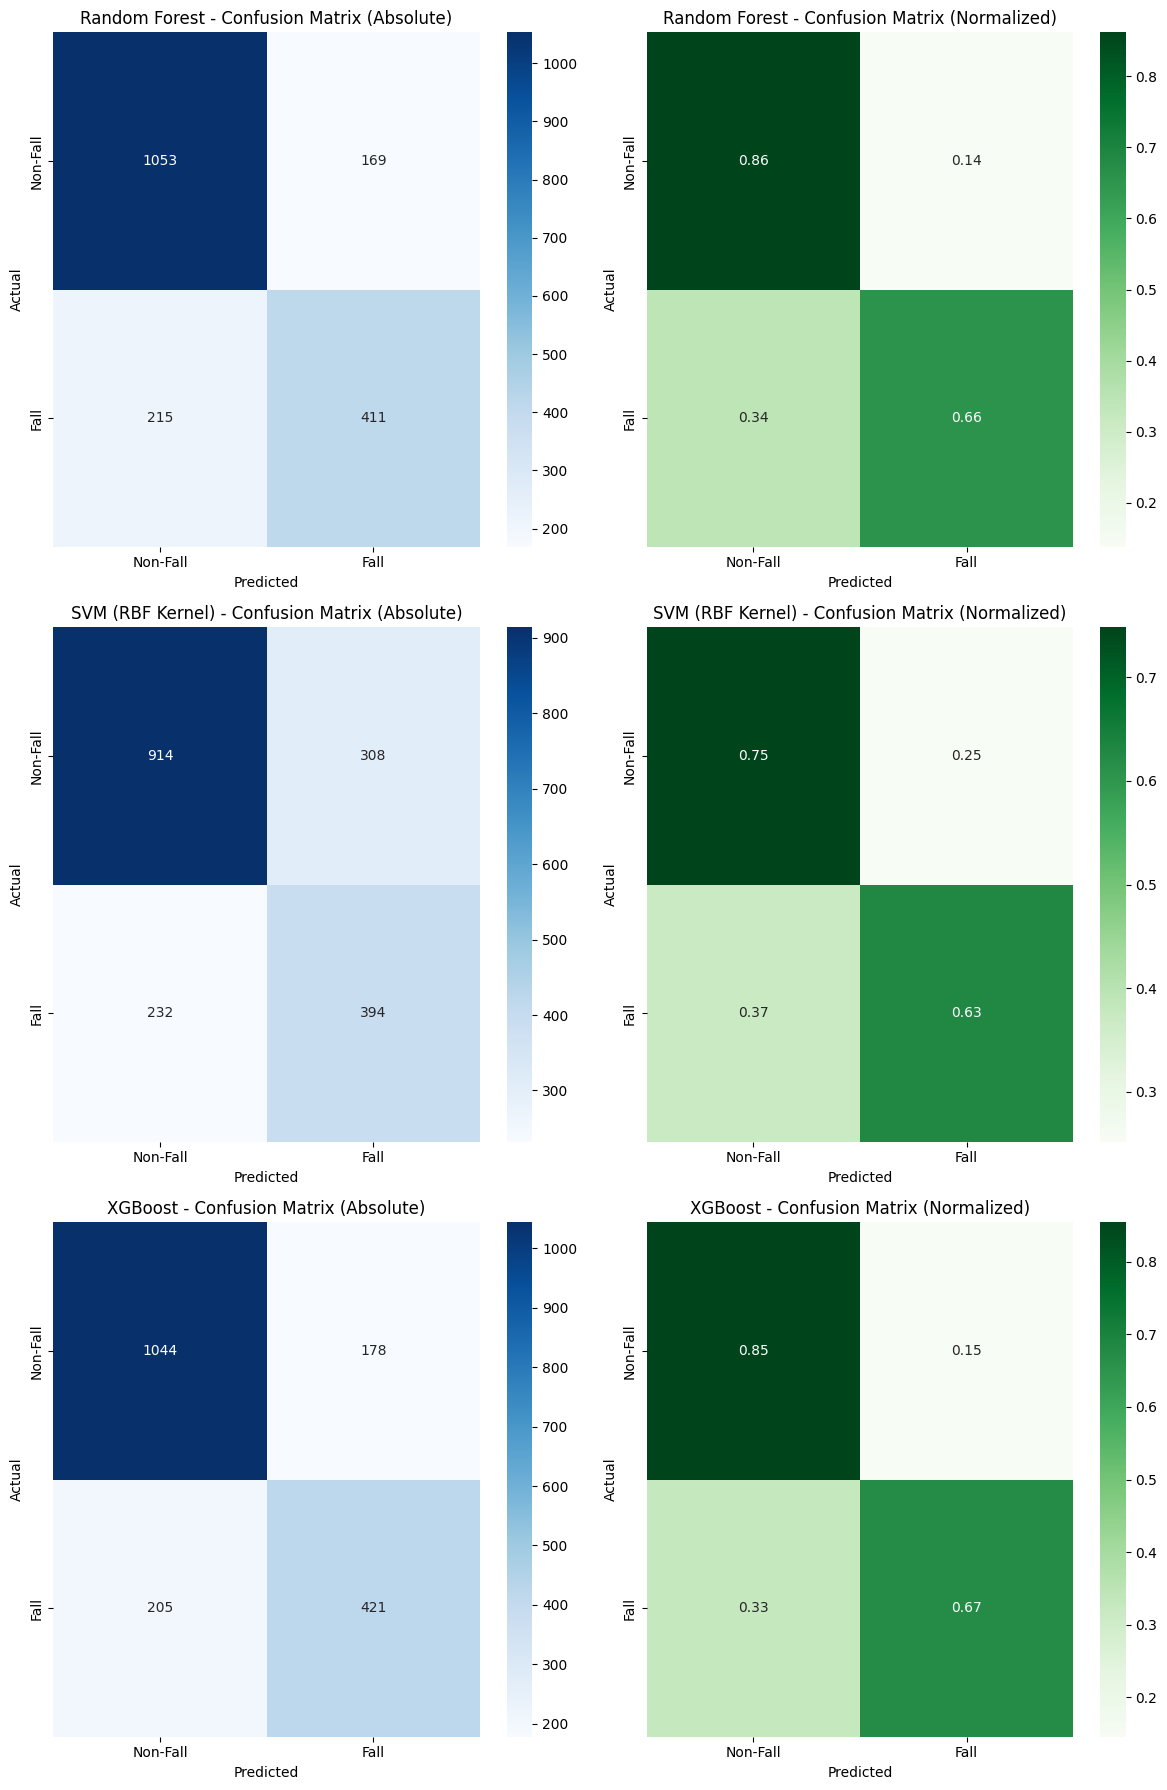

In [26]:
fig, axes = plt.subplots(len(results), 2, figsize=(12, 6 * len(results)))
if len(results) == 1:
    axes = np.expand_dims(axes, axis=0)

for idx, (name, res) in enumerate(results.items()):
    sns.heatmap(res["conf_matrix"], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'], ax=axes[idx, 0])
    axes[idx, 0].set_title(f"{name} - Confusion Matrix (Absolute)")
    axes[idx, 0].set_xlabel("Predicted")
    axes[idx, 0].set_ylabel("Actual")

    sns.heatmap(res["conf_matrix_norm"], annot=True, fmt='.2f', cmap='Greens',
                xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'], ax=axes[idx, 1])
    axes[idx, 1].set_title(f"{name} - Confusion Matrix (Normalized)")
    axes[idx, 1].set_xlabel("Predicted")
    axes[idx, 1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## 5) Show classification reports

In [27]:
for name, res in results.items():
    print(f"\nClassification Report: {name}")
    display(pd.DataFrame(res["report"]).T)


Classification Report: Random Forest


,precision,recall,f1-score,support
0,0.830442,0.861702,0.845783,1222.000000
1,0.708621,0.656550,0.681592,626.000000
accuracy,0.792208,0.792208,0.792208,0.792208
macro avg,0.769531,0.759126,0.763688,1848.000000
weighted avg,0.789175,0.792208,0.790164,1848.000000



Classification Report: SVM (RBF Kernel)


,precision,recall,f1-score,support
0,0.797557,0.747954,0.771959,1222.000000
1,0.561254,0.629393,0.593373,626.000000
accuracy,0.707792,0.707792,0.707792,0.707792
macro avg,0.679405,0.688674,0.682666,1848.000000
weighted avg,0.717510,0.707792,0.711464,1848.000000



Classification Report: XGBoost


,precision,recall,f1-score,support
0,0.835869,0.854337,0.845002,1222.000000
1,0.702838,0.672524,0.687347,626.000000
accuracy,0.792749,0.792749,0.792749,0.792749
macro avg,0.769353,0.763431,0.766174,1848.000000
weighted avg,0.790805,0.792749,0.791597,1848.000000


## 6) Show ROC Curve

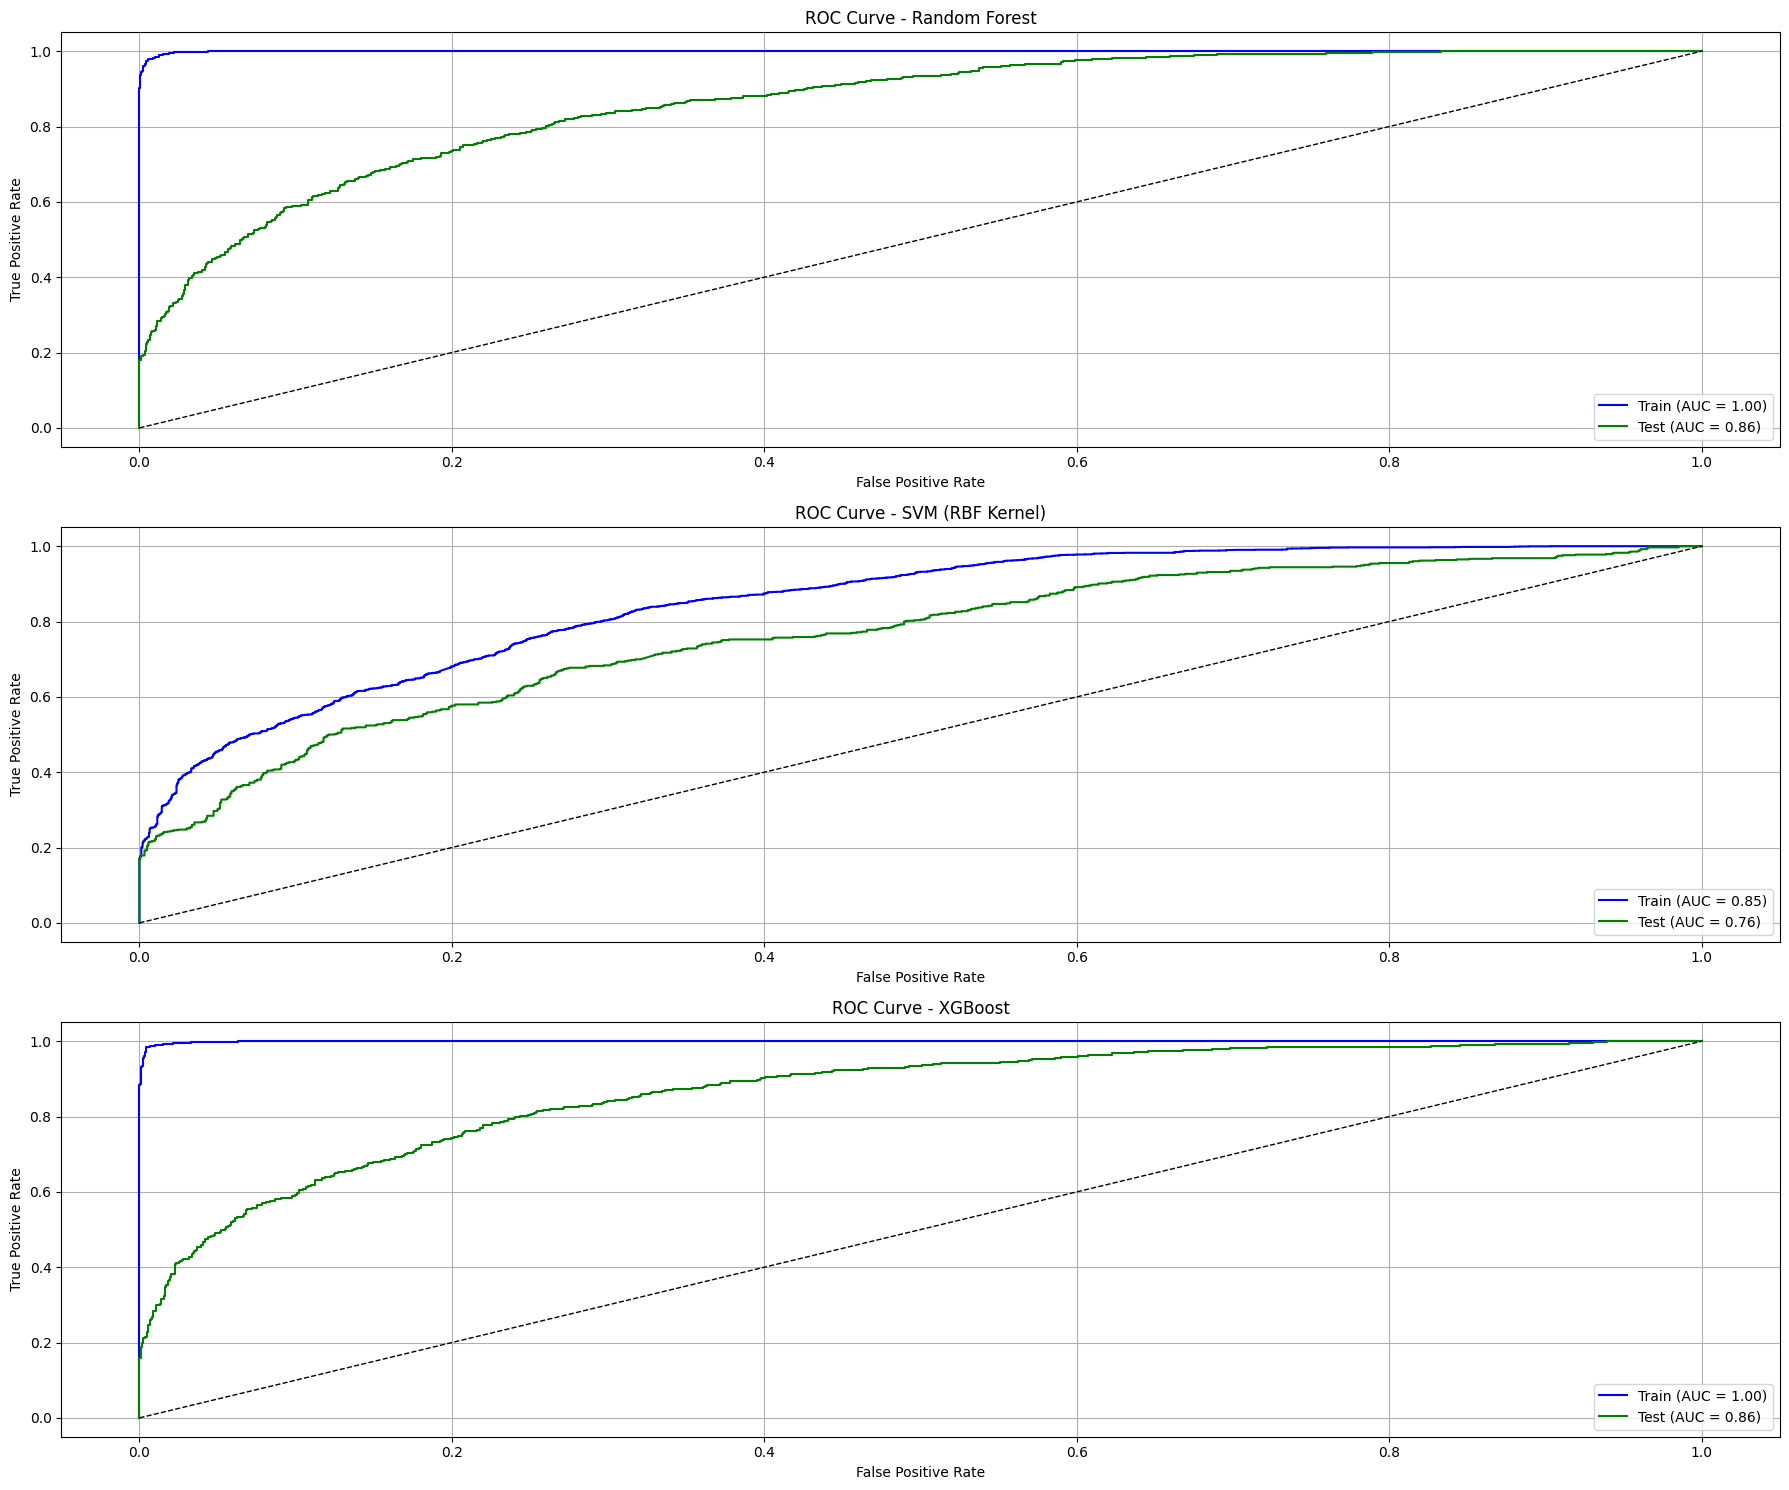

In [28]:
plt.figure(figsize=(18, 5 * len(results)))

for idx, (name, res) in enumerate(results.items()):
    plt.subplot(len(results), 1, idx + 1)
    plt.plot(res["fpr_train"], res["tpr_train"], label=f"Train (AUC = {res['auc_train']:.2f})", color='blue')
    plt.plot(res["fpr_test"], res["tpr_test"], label=f"Test (AUC = {res['auc_test']:.2f})", color='green')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f"ROC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)

plt.tight_layout()
plt.show()